In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

# Python native libs
import os
import enum
from collections import namedtuple
import argparse
import numbers
import math


# Deep learning related imports
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt  # visualizations

In [60]:
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU




In [61]:
DEVICE

device(type='cuda', index=2)

In [203]:
from utils.constants import *
from utils.utils import *

class SupportedModels(enum.Enum):
    VGG16 = 0
    VGG16_EXPERIMENTAL = 1
    GOOGLENET = 2
    RESNET50 = 3
    ALEXNET = 4
    VIT = 5

def fetch_and_prepare_model(model_type, pretrained_weights, device):
    if model_type == SupportedModels.VGG16.name:
        model = Vgg16(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.VGG16_EXPERIMENTAL.name:
        model = Vgg16Experimental(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.GOOGLENET.name:
        model = GoogLeNet(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.RESNET50.name:
        model = ResNet50(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.ALEXNET.name:
        model = AlexNet(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.VIT.name:
        model = ViT(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    else:
        raise Exception('Model not yet supported.')
    return model

In [261]:
vit = models.vit_l_(pretrained=True, progress = True).eval().to(DEVICE)

ValueError: No weights available for model vit_h_14

In [18]:
for name, _ in vit.named_modules():
    print(name)


conv_proj
encoder
encoder.dropout
encoder.layers
encoder.layers.encoder_layer_0
encoder.layers.encoder_layer_0.ln_1
encoder.layers.encoder_layer_0.self_attention
encoder.layers.encoder_layer_0.self_attention.out_proj
encoder.layers.encoder_layer_0.dropout
encoder.layers.encoder_layer_0.ln_2
encoder.layers.encoder_layer_0.mlp
encoder.layers.encoder_layer_0.mlp.0
encoder.layers.encoder_layer_0.mlp.1
encoder.layers.encoder_layer_0.mlp.2
encoder.layers.encoder_layer_0.mlp.3
encoder.layers.encoder_layer_0.mlp.4
encoder.layers.encoder_layer_1
encoder.layers.encoder_layer_1.ln_1
encoder.layers.encoder_layer_1.self_attention
encoder.layers.encoder_layer_1.self_attention.out_proj
encoder.layers.encoder_layer_1.dropout
encoder.layers.encoder_layer_1.ln_2
encoder.layers.encoder_layer_1.mlp
encoder.layers.encoder_layer_1.mlp.0
encoder.layers.encoder_layer_1.mlp.1
encoder.layers.encoder_layer_1.mlp.2
encoder.layers.encoder_layer_1.mlp.3
encoder.layers.encoder_layer_1.mlp.4
encoder.layers.encoder_l

In [62]:
vit = vit.to(DEVICE)

In [189]:
import cv2

input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_width = 224  # arbitrary
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape=[224, 224])
img = pre_process_numpy_img(img)
input_tensor = pytorch_input_adapter(img, DEVICE)

x = vit._process_input(input_tensor)
n = x.shape[0]

batch_class_token = vit.class_token.expand(n, -1, -1)
y = torch.cat([batch_class_token, x], dim=1)

#original = vit.encoder(y)

#y = y + vit.encoder.pos_embedding
#for i in range(12):
#    y = layers[i](y)
#y = vit.encoder.ln(y)

In [190]:
layers_of_interest = [5]

x = vit._process_input(input_tensor)
# N x 196 x 768
n = x.shape[0]
# Expand the class token to the full batch
batch_class_token = vit.class_token.expand(n,-1,-1)
x = torch.cat([batch_class_token, x], dim=1)
# N x 197 x 178
x = x + vit.encoder.pos_embedding

for i in range(12):
    layer = vit.encoder.layers[i]
    if i in layers_of_interest:
        input = x
        x = layer.ln_1(x)
        print(f"ln_1; {x.shape}")
        x, _ = layer.self_attention(x, x, x, need_weights=False)
        print(f"self_att; {x.shape}")
        self_attention_5 = x
        x = x + input

        y = layer.ln_2(x)
        # 1 x 768
        y = layer.mlp[0](y) ## Linear
        y = layer.mlp[1](y) ## GELU
        # 1 x 3072
        gelu_5 = y
        y = layer.mlp[3](y) ## Linear
        
        x = x + y
    else:
        x = layer(x)

ln_1; torch.Size([1, 197, 768])
self_att; torch.Size([1, 197, 768])


In [118]:
layers[0].ln_1

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [111]:
type(vit.encoder.pos_embedding)

torch.nn.parameter.Parameter

In [165]:
layers[0].mlp

MLPBlock(
  (0): Linear(in_features=768, out_features=3072, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=3072, out_features=768, bias=True)
  (4): Dropout(p=0.0, inplace=False)
)

In [187]:
x = torch.rand((1, 768)).to(DEVICE)

mlp = layers[0].mlp.eval()
x_0 = mlp(x)


    
x = mlp[0](x)
print(x.shape)
x = mlp[1](x)
print(x.shape)
#x = mlp[2](x)
x = mlp[3](x)
print(x.shape)
#x = mlp[4](x)

(x == x_0).all()

torch.Size([1, 3072])
torch.Size([1, 3072])
torch.Size([1, 768])


tensor(True, device='cuda:2')

In [181]:
mlp = layers[0].mlp.eval()

# First method
x = mlp(x.clone())
x_0 = x.clone()

# Reset x
x = x_0.clone()

# Reproduce forward method step by step
outputs = []
for i, layer in enumerate(mlp):
    print(layer)
    x = layer(x)
    outputs.append(x.clone())

    if not (x == outputs[-1]).all():
        print(f"Discrepancy detected at layer {i}")
        print(f"Max difference: {(x - outputs[-1]).abs().max()}")


Linear(in_features=768, out_features=3072, bias=True)
GELU(approximate='none')
Dropout(p=0.0, inplace=False)
Linear(in_features=3072, out_features=768, bias=True)
Dropout(p=0.0, inplace=False)


In [177]:
diff = (x - x_0).abs()
max_diff = diff.max()
max_diff_idx = diff.argmax()

print(f"Max difference: {max_diff}")
print(f"Index of max difference: {max_diff_idx}")
print(f"Value in x at this index: {x.view(-1)[max_diff_idx]}")
print(f"Value in x_0 at this index: {x_0.view(-1)[max_diff_idx]}")


Max difference: 160.9066162109375
Index of max difference: 743
Value in x at this index: 71.69284057617188
Value in x_0 at this index: -89.21377563476562


In [99]:
layers = [vit.encoder.layers[i] for i in range(12)]

In [252]:
class ViT(torch.nn.Module):
    def __init__(self, pretrained_weights, requires_grad=False, show_progress=False):

        super().__init__()
        
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            vit = models.vit_b_16(pretrained=True, progress = True).eval().to(DEVICE)
        else:
            raise Exception(f'Pretrained weights {pretrained_weights} not yet supported for {self.__class__.__name__} model.')
        
        self.process_input = vit._process_input
        self.class_token = vit.class_token
        self.pos_embedding = vit.encoder.pos_embedding
        
        self.num_layers = 12
        self.layers = vit.encoder.layers

        self.layers_of_interest = [11]
        self.layer_names = ["self_attention", "gelu"]
        
    def forward(self, x):
        x = self.process_input(x)
        # N x 196 x 768
        n = x.shape[0]
        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n,-1,-1)
        x = torch.cat([batch_class_token, x], dim=1)
        # N x 197 x 178
        x = x + self.pos_embedding

        for i in range(self.num_layers):
            layer = self.layers[i]
            if i in self.layers_of_interest:
                input = x
                x = layer.ln_1(x)
                x, _ = layer.self_attention(x, x, x, need_weights=False)
                self_attention = x
                x = x + input
        
                y = layer.ln_2(x)
                # 1 x 768
                y = layer.mlp[0](y) ## Linear
                y = layer.mlp[1](y) ## GELU
                # 1 x 3072
                gelu = y
                y = layer.mlp[3](y) ## Linear
                
                x = x + y
            else:
                x = layer(x)
        

        # Feel free to experiment with different layers.
        vit_outputs = namedtuple("ViTOutputs", self.layer_names)
        out = vit_outputs(self_attention, gelu)
        return out
            

In [35]:
alexnet = models.alexnet(pretrained=True, progress=False).eval()

/home/davide/.venvs/deepdream/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davide/.venvs/deepdream/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/davide/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


In [43]:
#list(vit.named_modules())

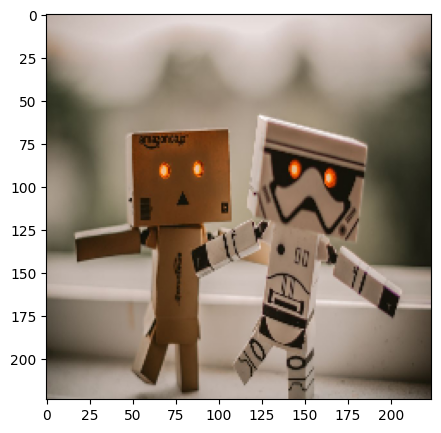

In [227]:
input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape=[224, 224])

fig = plt.figure(figsize=(7.5,5), dpi=100)  # otherwise plots are really small in Jupyter Notebook
plt.imshow(img)
plt.show()

In [257]:
# Only a small subset is exposed by design to avoid cluttering
parser = argparse.ArgumentParser()

# Common params
parser.add_argument("--input", type=str, help="Input IMAGE or VIDEO name that will be used for dreaming", default='figures.jpg')
parser.add_argument("--img_width", type=int, help="Resize input image to this width", default=600)
parser.add_argument("--layers_to_use", type=str, nargs='+', help="Layer whose activations we should maximize while dreaming", default=['self_attention'])
parser.add_argument("--model_name", choices=[m.name for m in SupportedModels],
                    help="Neural network (model) to use for dreaming", default=SupportedModels.VIT.name)
parser.add_argument("--pretrained_weights", choices=[pw.name for pw in SupportedPretrainedWeights],
                    help="Pretrained weights to use for the above model", default=SupportedPretrainedWeights.IMAGENET.name)

# Main params for experimentation (especially pyramid_size and pyramid_ratio)
parser.add_argument("--pyramid_size", type=int, help="Number of images in an image pyramid", default=3)
parser.add_argument("--pyramid_ratio", type=float, help="Ratio of image sizes in the pyramid", default=1.8)
parser.add_argument("--num_gradient_ascent_iterations", type=int, help="Number of gradient ascent iterations", default=100)
parser.add_argument("--lr", type=float, help="Learning rate i.e. step size in gradient ascent", default=0.09)

# You usually won't need to change these as often
parser.add_argument("--should_display", type=bool, help="Display intermediate dreaming results", default=False)
parser.add_argument("--spatial_shift_size", type=int, help='Number of pixels to randomly shift image before grad ascent', default=32)
parser.add_argument("--smoothing_coefficient", type=float, help='Directly controls standard deviation for gradient smoothing', default=0.5)
parser.add_argument("--use_noise", type=bool, help="Use noise as a starting point instead of input image", default=False)
args = parser.parse_args('')  # important to put '' in Jupyter otherwise it will complain

# Wrapping configuration into a dictionary
config = dict()
for arg in vars(args):
    config[arg] = getattr(args, arg)
config['dump_dir'] = os.path.join(OUT_IMAGES_PATH, f'{config["model_name"]}_{config["pretrained_weights"]}')
config['input'] = os.path.basename(config['input'])  # handle absolute and relative paths

In [258]:
#from deepdream import *
input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape=[224, 224])

dream_img = deep_dream_static_image(config, img)  # yep a single liner


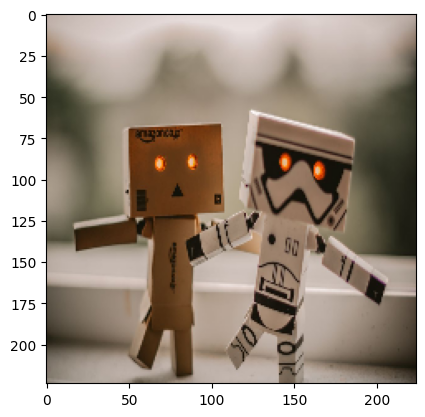

In [259]:
plt.imshow(img)

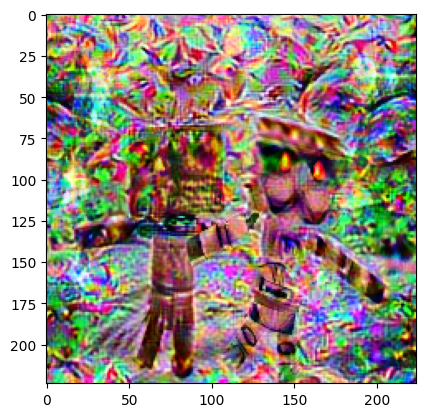

In [260]:
plt.imshow(dream_img)

In [217]:
pre_process_numpy_img(img).shape

(224, 224, 3)

In [218]:
def deep_dream_static_image(config, img=None):
    model = fetch_and_prepare_model(config['model_name'], config['pretrained_weights'], DEVICE)

    try:
        layer_ids_to_use = [model.layer_names.index(layer_name) for layer_name in config['layers_to_use']]
    except Exception as e:  # making sure you set the correct layer name for this specific model
        print(f'Invalid layer names {[layer_name for layer_name in config["layers_to_use"]]}.')
        print(f'Available layers for model {config["model_name"]} are {model.layer_names}.')
        return

    if img is None:  # load either the provided image or start from a pure noise image
        img_path = os.path.join(INPUT_DATA_PATH, config['input'])
        # load a numpy, [0, 1] range, channel-last, RGB image
        img = load_image(img_path, target_shape=config['img_width'])
        if config['use_noise']:
            shape = img.shape
            img = np.random.uniform(low=0.0, high=1.0, size=shape).astype(np.float32)

    img = pre_process_numpy_img(img)
    original_shape = img.shape[:-1]  # save initial height and width

    # Note: simply rescaling the whole result (and not only details, see original implementation) gave me better results
    # Going from smaller to bigger resolution (from pyramid top to bottom)
    for pyramid_level in range(config['pyramid_size']):
        new_shape = get_new_shape(config, original_shape, pyramid_level)
        #img = cv.resize(img, (new_shape[1], new_shape[0]))  # resize depending on the current pyramid level
        input_tensor = pytorch_input_adapter(img, DEVICE)  # convert to trainable tensor

        for iteration in range(config['num_gradient_ascent_iterations']):
            
            # Introduce some randomness, it will give us more diverse results especially when you're making videos
            h_shift, w_shift = np.random.randint(-config['spatial_shift_size'], config['spatial_shift_size'] + 1, 2)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift)

            # This is where the magic happens, treat it as a black box until the next cell
            gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration)

            # Roll back by the same amount as above (hence should_undo=True)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift, should_undo=True)

        img = pytorch_output_adapter(input_tensor)

    return post_process_numpy_img(img)